In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def makeDummyImage1():
    image = np.zeros((10, 10), dtype=np.uint8)
    image[2:6, 2:6] = 255
    image[6:8, 6:8] = 255
    image[7:9, 3:5] = 255
    return image

def makeDummyImage2():
    image = np.zeros((8, 8), dtype=np.uint8)
    image[3:6, 1] = 255
    image[2:6, 2] = 255
    image[1:6, 3] = 255
    image[1:4, 4] = 255
    image[1:3, 5] = 255
    return image

def makeDummyImage3():
    image = np.zeros((8, 8), dtype=np.uint8)
    image[0:3, 4:7] = 255
    image[3  , 3:5] = 255
    image[4:7, 1:4] = 255
    return image

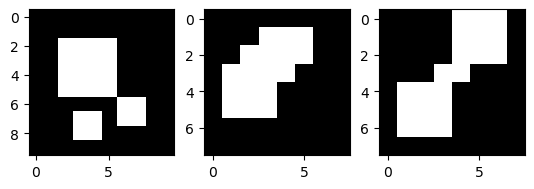

In [3]:
imagesDir   = os.path.join("..\\..\\", "images", "Binary")
imagePath   = os.path.join(imagesDir, "MultipleObjects3.png")

images = [makeDummyImage1(), makeDummyImage2(), makeDummyImage3()]

for i, img in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(img, cmap=plt.cm.gray)

# Morphological Operations
[HIPR2](https://homepages.inf.ed.ac.uk/rbf/HIPR2/hipr_top.htm) is a great online resouce for image proccessing easily explanning the theory and have Java implementation for many operators. you can use the [User Guide](https://homepages.inf.ed.ac.uk/rbf/HIPR2/usrguide.htm) and [Guide to Contents](https://homepages.inf.ed.ac.uk/rbf/HIPR2/guidecon.htm) to navigate the website topics. Here we will focus on the [Morphological Operations](https://homepages.inf.ed.ac.uk/rbf/HIPR2/morops.htm).

In [4]:
# Make sure that a pixel position is inside image boundries
def isPosInShape(pos, shape):
    for i in range(len(pos)):
        if pos[i] < 0 or pos[i] >= shape[i]:
            return False
    return True

### Erosion / Dilation

In [5]:
def morphologicalErode(image, kernel):
    def operateOnPixel(r, c):
        half = (kernel.shape[0] // 2, kernel.shape[1] // 2)
        if not image[r][c]:
            return 0
        indices = [(r+i-half[0], c+j-half[1]) for i in range(kernel.shape[0]) for j in range(kernel.shape[1]) if kernel[i][j] == 1]
        indices = [idx for idx in indices if isPosInShape(idx, image.shape)]
        for idx in indices:
            if not image[idx]:
                return 0
        return 1
    
    outputImage = np.zeros_like(image)
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            outputImage[r][c] = operateOnPixel(r, c)
    return outputImage

def morphologicalDilate(image, kernel):
    def operateOnPixel(r, c):
        half = (kernel.shape[0] // 2, kernel.shape[1] // 2)
        if image[r][c]:
            return 1
        indices = [(r+i-half[0], c+j-half[1]) for i in range(kernel.shape[0]) for j in range(kernel.shape[1]) if kernel[i][j] == 1]
        indices = [idx for idx in indices if isPosInShape(idx, image.shape)]
        for idx in indices:
            if image[idx]:
                return 1
        return 0
    
    outputImage = np.zeros_like(image)
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            outputImage[r][c] = operateOnPixel(r, c)
    return outputImage

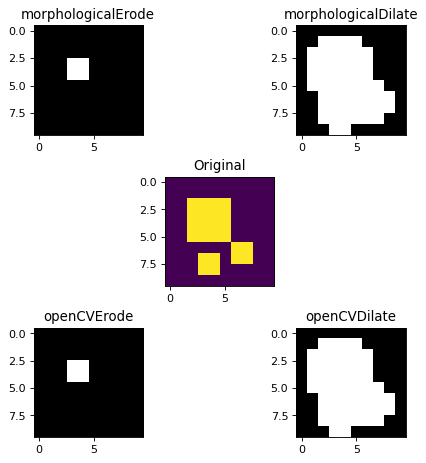

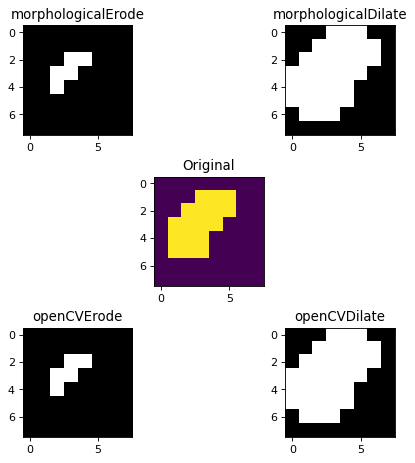

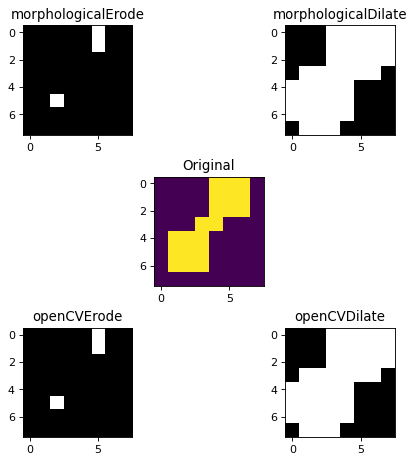

In [6]:
kernel = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
], dtype=np.uint8)

for i, img in enumerate(images):
    plt.figure(figsize=(6, 9), dpi=80)
    plt.subplot(231)
    plt.imshow(morphologicalErode(img, kernel), cmap=plt.cm.gray)
    plt.title("morphologicalErode")

    plt.subplot(234)
    plt.imshow(cv2.erode(img, kernel), cmap=plt.cm.gray)
    plt.title("openCVErode")

    plt.subplot(132)
    plt.imshow(img)
    plt.title("Original")

    plt.subplot(233)
    plt.imshow(morphologicalDilate(img, kernel), cmap=plt.cm.gray)
    plt.title("morphologicalDilate")

    plt.subplot(236)
    plt.imshow(cv2.dilate(img, kernel), cmap=plt.cm.gray)
    plt.title("openCVDilate")

    plt.show()

### Openning / Closing

In [7]:
def morphologicalOpen(image, kernel):
    return morphologicalDilate(morphologicalErode(image, kernel), kernel)

def morphologicalClose(image, kernel):
    return morphologicalErode(morphologicalDilate(image, kernel), kernel)

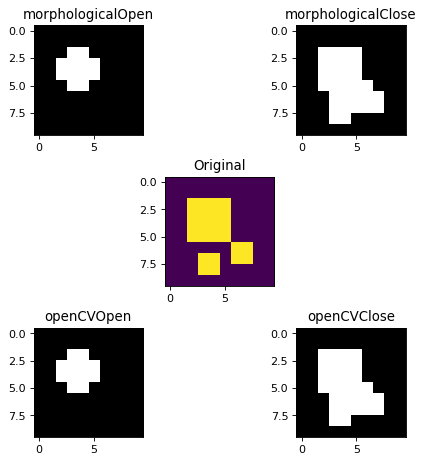

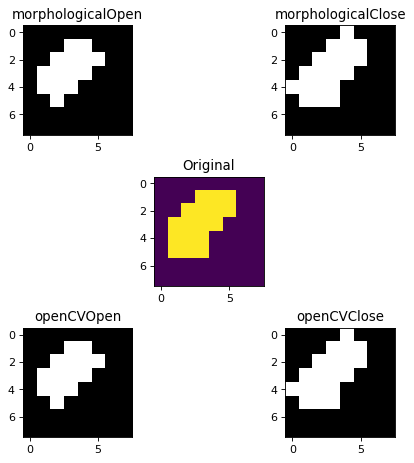

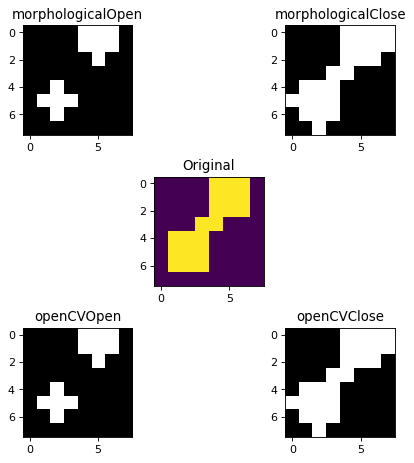

In [8]:
kernel = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
], dtype=np.uint8)

for i, img in enumerate(images):
    plt.figure(figsize=(6, 9), dpi=80)
    plt.subplot(231)
    plt.imshow(morphologicalOpen(img, kernel), cmap=plt.cm.gray)
    plt.title("morphologicalOpen")

    plt.subplot(234)
    plt.imshow(cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel), cmap=plt.cm.gray)
    plt.title("openCVOpen")

    plt.subplot(132)
    plt.imshow(img)
    plt.title("Original")

    plt.subplot(233)
    plt.imshow(morphologicalClose(img, kernel), cmap=plt.cm.gray)
    plt.title("morphologicalClose")

    plt.subplot(236)
    plt.imshow(cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel), cmap=plt.cm.gray)
    plt.title("openCVClose")

    plt.show()

### Hit-Miss

In [9]:
def morphologicalHitMiss(image, kernel):
    def operateOnPixel(r, c):
        half = (kernel.shape[0] // 2, kernel.shape[1] // 2)
        indices = [(i, j, r+i-half[0], c+j-half[1]) for i in range(kernel.shape[0]) for j in range(kernel.shape[1]) if kernel[i][j] == 1 or kernel[i][j] == 0]
        for idx in indices:
            if not isPosInShape((idx[2:]), image.shape) or kernel[idx[:2]] != image[idx[2:]] // 255:
                return 0
        return 1

    outputImage = np.zeros_like(image)
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            outputImage[r][c] = operateOnPixel(r, c)
    return outputImage

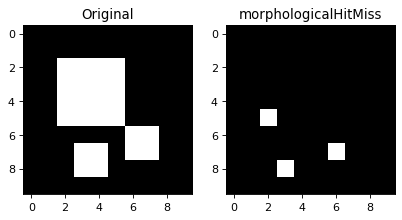

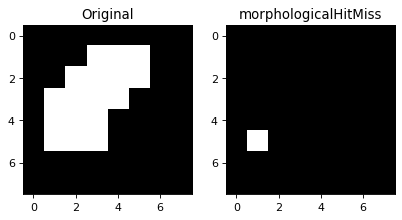

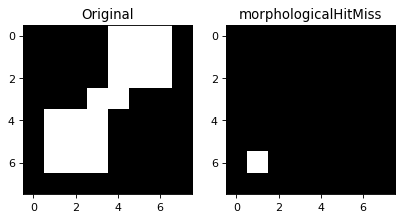

In [10]:
# 0: Background, 1: Foreground, 2: Don't care
# kernel that match the bottom left corner pattern 
kernel = np.array([
    [2, 1, 2],
    [0, 1, 1],
    [0, 0, 2]
])

for i, img in enumerate(images):
    plt.figure(figsize=(6, 18), dpi=80)
    plt.subplot(121)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title("Original")
    
    plt.subplot(122)
    plt.imshow(morphologicalHitMiss(img, kernel), cmap=plt.cm.gray)
    plt.title("morphologicalHitMiss")

### Thinning
Regarding to "Thinning" both the theory and the implementation are quite complex, I might get back to this later.
But you can check HIPR2 content about [Thinning](https://homepages.inf.ed.ac.uk/rbf/HIPR2/thin.htm) for refrence.